In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

rng = np.random.default_rng()

In [2]:

n = 1000 # number of pure points
m = 40 # number of corrupted points

d = 10 # dimension of noise

l = 100 # number of hidden neurons

C = 1 # SNR
D = C # loss margin

test_n = 10 # number of test points

use_bias=True

EPOCHS = 100 # number of training steps
BATCH_SIZE = 1 # batch size
LR = 0.01 # learning rate
DROPOUT_RATE = 0

In [3]:
# initialize parameters

X = rng.standard_normal(size=(n+m,d+1))/ np.sqrt(d)


y = np.zeros((n+m,1))
y[:n//2] = 1
y[n//2:n] = -1
y[n:n+m//2] = 1
y[-m//2:] = -1

X[:,0] = C*y.squeeze() # set signal dimension

y_train = y.copy()
y_train[-m:] = -y_train[-m:]
y_train[y_train < 0] = 0

X = torch.tensor(X, requires_grad=False)
y = torch.tensor(y, requires_grad=False)
y_train = torch.tensor(y_train, requires_grad=False)

W = torch.tensor(rng.standard_normal(size=(l,d+1)), requires_grad=True)
a = torch.tensor(rng.standard_normal(size=(1,l)), requires_grad=True)

if use_bias:
    b = torch.tensor(rng.standard_normal(size=(l,1)), requires_grad=True)

In [4]:
# train

relu = torch.nn.ReLU()
drop = torch.nn.Dropout(p=DROPOUT_RATE)

if use_bias:
    optimizer = torch.optim.SGD([W,a,b], lr=LR)
else:
    optimizer = torch.optim.SGD([W,a], lr=LR)

# cross entropy loss
#loss_fn = torch.nn.BCEWithLogitsLoss()
# hinge loss
loss_fn = lambda output, y_train : torch.sum(relu(D - (2*y_train-1)*output))

losses = np.zeros((EPOCHS,))

def model_forward(X, test=False):
    preactivations = W @ torch.t(X)
    if use_bias:
        preactivations = preactivations + b
    if not test:
        preactivations = drop(preactivations)
    return torch.t(a @ relu(preactivations))

for i in tqdm(range(EPOCHS)):
    indices = np.arange(n+m)
    rng.shuffle(indices)
    indices = indices.reshape((BATCH_SIZE,-1))
    
    e_loss = 0
    for j in range(indices.shape[1]):
        batch_inds = indices[:,j].squeeze()
        optimizer.zero_grad()
        X_batch = X[batch_inds,:].reshape((-1,d+1))
        
        # infinite uncorrupted training set, seems to work better
        # comment out if undesired
        if batch_inds < n:
            X_batch[1:] = torch.tensor(rng.standard_normal(size=(1,d+1))/ np.sqrt(d), requires_grad=False)
            
            
        output = model_forward(X_batch)
        loss = loss_fn(output, y_train[batch_inds].reshape((-1,1)))
        loss.backward()
        optimizer.step()
        
        e_loss += loss.detach().numpy()
        
    losses[i] = loss_fn(model_forward(X), y_train)
    

100%|█████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]


24.311455928327906


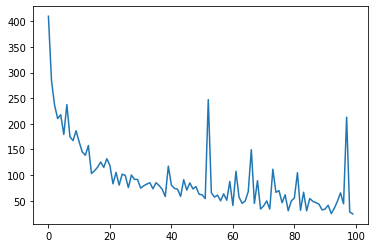

In [5]:
plt.plot(losses)
print(losses[-1])

In [6]:
output = model_forward(X, test=True)
print(torch.sum((output[:n]>0) == y_train[:n]).item(), n, torch.sum((output[:n]>0) == y_train[:n]).item()/n)
print(torch.sum((output[-m:]>0) == y_train[-m:]).item(), m, torch.sum((output[-m:]>0) == y_train[-m:]).item()/m)
print(torch.sum((output>0) == y_train).item(), n+m, torch.sum((output>0) == y_train).item()/(n+m))

999 1000 0.999
36 40 0.9
1035 1040 0.9951923076923077


In [7]:
test_X = torch.tensor(rng.standard_normal(size=(test_n,d+1)), requires_grad = False) / np.sqrt(d)
test_X[:test_n//2,0] = C
test_X[test_n//2:,0] = -C
print(model_forward(test_X, test=True))

tensor([[ 5.4362],
        [ 3.5057],
        [ 4.1574],
        [ 5.6392],
        [ 7.3480],
        [-4.4773],
        [-2.2879],
        [-2.5043],
        [-8.1601],
        [-4.2102]], dtype=torch.float64, grad_fn=<TBackward>)


In [8]:
print(np.linalg.norm(W.detach().numpy()[:,1:], axis=1))

[3.29427893 2.1779641  3.39236843 3.32140583 2.99703953 3.37087504
 3.4543389  2.93062497 3.31307921 2.94367255 3.73581741 2.63847502
 2.68610037 1.70844894 3.49611908 4.33551796 3.06930529 2.48851197
 3.11785934 4.10803434 1.37777626 3.79905916 3.13240221 4.10256815
 2.38711809 4.26649952 3.38613266 3.65373334 2.25327999 2.82574601
 3.78286291 2.75231639 4.14922002 3.32336528 3.73610101 3.10397085
 3.71820223 3.61654631 2.83051504 3.77334909 4.28442243 3.18160197
 2.90758703 3.70487194 3.84170143 4.6217823  2.88177875 2.08320355
 2.21721874 2.54548809 3.55272481 1.9187607  2.67763619 3.19181329
 3.25378628 3.18152986 2.41809313 3.89209637 3.63871832 2.5630058
 3.26412757 2.63502213 2.13756589 3.47457253 3.02487322 4.06962365
 3.3153464  3.22120307 2.72788296 2.26551118 4.26523296 3.98083096
 3.92703381 3.79530034 3.17415758 3.09707054 3.56386357 2.18027432
 2.40562126 3.1196871  2.33488541 2.76443492 3.10493896 2.64504976
 3.75671511 3.05530605 3.94724111 2.53675574 2.80969893 3.44749

In [9]:
print(W.detach().numpy()[:,0])

[ 0.10610926 -0.80414569  0.28668809 -0.25049222 -0.98108926 -1.17024911
  0.74240746  0.60944578 -0.04290286 -0.06408065  0.49756071  0.90033487
  0.20602317  1.44145342 -0.69863837 -0.21713445  0.29824765 -0.3041391
  0.52967948 -1.6558592  -1.73239135  0.31089245 -0.43677266  0.33443072
 -0.6151374  -0.38995706  0.827352    0.92475406  2.47440967 -2.28121583
 -0.44809873  2.4199334   0.91308314  0.6233928  -0.66930626 -1.4739356
 -0.02528747  0.21342447 -0.33760923  0.33260475 -1.58588856 -0.30113667
  1.16052901  0.05530491 -0.04088201  0.99376131  1.18010518 -2.44988639
 -1.03310954  0.23530502  0.68801095 -0.18377965  0.30464257 -0.91654503
 -0.33078278  0.23840754 -1.06127515  0.75277552  1.26606643  0.02223338
 -1.18806827  0.28008882  1.55505071  0.8954318   2.72718448 -0.30884742
  0.49631016 -1.24315112  0.25065221 -1.52473357  0.01333199 -1.50340556
 -0.97226911 -0.74781237 -0.12516005 -1.19964256  0.87503372  0.47640999
  0.57286732  0.22534123  0.59182816  0.49749038  0.0

In [10]:
print(np.linalg.norm(W.detach().numpy()[:,1:], axis=1) / W.detach().numpy()[:,0])

[  31.0461011    -2.70841977   11.83295916  -13.25951677   -3.05480823
   -2.88047648    4.65288817    4.80867215  -77.22281091  -45.93699293
    7.50826443    2.93054852   13.03785593    1.1852266    -5.00418991
  -19.96697464   10.29112999   -8.18215082    5.88631326   -2.48090801
   -0.79530313   12.21985001   -7.17169938   12.26731847   -3.88062585
  -10.94094693    4.09273521    3.95103249    0.91063336   -1.23870174
   -8.44203       1.13735212    4.54418642    5.33109348   -5.58204998
   -2.1059067  -147.03733091   16.94532186   -8.38399791   11.34484417
   -2.70159111  -10.56530914    2.50539798   66.98993105  -93.97046095
    4.65079718    2.44196771   -0.8503266    -2.14616035   10.81782309
    5.16376199  -10.44055037    8.78943543   -3.48244022   -9.83662547
   13.3449215    -2.27847899    5.17032804    2.87403427  115.27736185
   -2.74742424    9.40780899    1.37459562    3.88033186    1.10915607
  -13.17680961    6.67998894   -2.5911597    10.88313944   -1.48584069
  319.

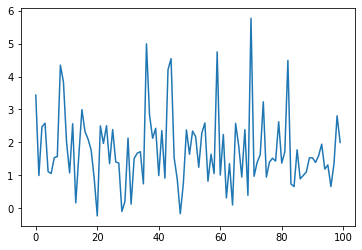

In [11]:
plt.plot(np.log(np.abs(np.linalg.norm(W.detach().numpy()[:,1:], axis=1) / W.detach().numpy()[:,0])))

In [12]:
print(W.detach().numpy()[:,0] * a.detach().numpy())

[[-0.01069515 -0.46643998 -0.17517561  0.17902391  2.34611064  1.21039558
  -0.2114499  -1.00668637 -0.049391    0.05459874  0.30972236 -1.14949871
   0.30081013 -0.4478084   0.18360429  0.22107707 -0.40114097 -0.08046094
  -0.43580881 -0.52620004  1.35351767  0.59598412  0.07035422  0.32942818
  -0.69301036 -0.47054994 -0.94748305  0.68329541  3.13431203  0.40041056
  -0.39631121 -0.7005392  -0.46106977  0.069057    0.25182293 -2.11223046
   0.02276516  0.46702709  0.09885205 -0.31175756  1.80286073  0.13297209
  -1.35686083 -0.04953869  0.07054033  0.26537272  0.6520955   0.46533694
  -2.32285172  0.11987266  0.40168439 -0.14226498 -0.16138457 -1.25592032
   0.01033011  0.03488843 -0.63021878 -0.40398376  1.64266586 -0.00474453
   2.5255142   0.21207564  1.61897711 -1.08251178  2.17945517 -0.13402474
  -0.14424499 -0.33229859 -0.38133021  0.57440575  0.0299526   2.37372141
  -0.7098449  -1.03188139 -0.06925087  0.60399727  2.08535498 -0.43641281
  -0.39999474 -0.34901662 -0.71637182 

In [13]:
print((W[:,1:] @ torch.t(X[-m:,1:])).detach().numpy())

[[-0.39035086 -0.48611768 -0.63740161 ...  0.62155864 -0.1101962
   0.130968  ]
 [ 0.75858992  0.84200088  0.3707224  ... -0.58552633 -1.50970886
   0.72176887]
 [-1.26281854 -0.90906456 -2.7739677  ...  1.36036923  1.7347017
  -0.48917957]
 ...
 [-0.6124366   0.20119976 -0.3359624  ...  0.27263576 -1.46952069
  -1.61960898]
 [ 0.6484516   1.0883205  -0.21034001 ... -1.47708068 -0.32293204
   1.26721656]
 [-1.13205853 -1.77775919  1.47511345 ...  1.38289518  0.70818809
  -0.75675077]]


In [14]:
print(b)

tensor([[-0.3408],
        [-0.0317],
        [ 0.7383],
        [ 0.7206],
        [-1.0845],
        [-0.7643],
        [ 0.4551],
        [-1.3336],
        [ 0.0607],
        [-0.6888],
        [-1.3644],
        [ 0.0298],
        [ 1.1423],
        [ 0.6650],
        [-0.3301],
        [ 0.3905],
        [-1.3722],
        [ 0.1072],
        [-0.9127],
        [ 1.2521],
        [ 0.5653],
        [-0.9636],
        [ 0.2994],
        [ 0.4253],
        [ 0.5120],
        [-0.0971],
        [-1.3439],
        [-0.4106],
        [ 0.2065],
        [ 0.6287],
        [-0.8623],
        [-0.4176],
        [ 0.0773],
        [ 1.0225],
        [ 0.1338],
        [ 0.4266],
        [-0.4832],
        [-1.1098],
        [ 0.8383],
        [ 0.0110],
        [ 0.5958],
        [ 0.3645],
        [ 0.6053],
        [-1.2527],
        [-0.8005],
        [-1.4077],
        [ 0.9118],
        [-1.0304],
        [-0.4667],
        [ 0.1902],
        [ 0.4959],
        [ 0.9708],
        [ 0.

In [15]:
print(a)

tensor([[-0.1008,  0.5800, -0.6110, -0.7147, -2.3913, -1.0343, -0.2848, -1.6518,
          1.1512, -0.8520,  0.6225, -1.2767,  1.4601, -0.3107, -0.2628, -1.0182,
         -1.3450,  0.2646, -0.8228,  0.3178, -0.7813,  1.9170, -0.1611,  0.9850,
          1.1266,  1.2067, -1.1452,  0.7389,  1.2667, -0.1755,  0.8844, -0.2895,
         -0.5050,  0.1108, -0.3762,  1.4331, -0.9003,  2.1883, -0.2928, -0.9373,
         -1.1368, -0.4416, -1.1692, -0.8957, -1.7255,  0.2670,  0.5526, -0.1899,
          2.2484,  0.5094,  0.5838,  0.7741, -0.5298,  1.3703, -0.0312,  0.1463,
          0.5938, -0.5367,  1.2975, -0.2134, -2.1257,  0.7572,  1.0411, -1.2089,
          0.7992,  0.4340, -0.2906,  0.2673, -1.5214, -0.3767,  2.2467, -1.5789,
          0.7301,  1.3799,  0.5533, -0.5035,  2.3832, -0.9160, -0.6982, -1.5488,
         -1.2104, -0.3710,  1.3074,  0.4803, -0.6642,  0.2502,  0.7742, -1.0678,
          0.5325,  0.3245,  1.1440, -0.5351, -1.3621, -0.3120, -1.0807,  0.9152,
         -1.6504, -0.0535,  